In [133]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score,
    recall_score, f1_score, matthews_corrcoef
)
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import os

import joblib

In [141]:
def save_model_metadata(model_name, parameters, metrics, model_path):
  

    metadata_file = "model_metadata.json"

    # Load existing data
    if os.path.exists(metadata_file):
        with open(metadata_file, "r") as file:
            model_registry = json.load(file)
    else:
        model_registry = {"models": {}}

    # Ensure "models" key exists
    if "models" not in model_registry:
        model_registry["models"] = {}

    # Update only this model_name
    model_registry["models"][model_name] = {
        "parameters": parameters,
        "final_metrics": metrics,
        "model_path": model_path
    }

    # Save back
    with open(metadata_file, "w") as file:
        json.dump(model_registry, file, indent=4)


In [122]:
# -------------------------------
# Evaluation Metrics
# -------------------------------
def compute_classification_metrics(y_true, y_pred):
    """
    Compute standard classification metrics.
    """
    return {
        "accuracy": round(accuracy_score(y_true, y_pred), 4),
        "auc": round(roc_auc_score(y_true, y_pred), 4),
        "precision": round(precision_score(y_true, y_pred), 4),
        "recall": round(recall_score(y_true, y_pred), 4),
        "f1_score": round(f1_score(y_true, y_pred), 4),
        "mcc": round(matthews_corrcoef(y_true, y_pred), 4),
    }


In [83]:
def preprocess_dataset(df, categorical_cols=None):
    """
    Generic preprocessing function that:
    - Creates cyclical features (if columns exist)
    - Applies binary encoding
    - Applies ordinal encoding
    - Applies cyclical month encoding
    - Returns transformed dataframe
    
    Parameters:
        df (pd.DataFrame): Input dataset (train or test)
        categorical_cols (list): Optional list of categorical columns to display
        
    Returns:
        pd.DataFrame: Transformed dataframe
    """
    
    df = df.copy()
    
    # ============================================
    # Cyclical + Engineered Features
    # ============================================
    
    if 'duration' in df.columns:
        df['duration_sin'] = np.sin(2 * np.pi * df['duration'] / 540).astype('float32')
        df['duration_cos'] = np.cos(2 * np.pi * df['duration'] / 540).astype('float32')
    
    if 'balance' in df.columns:
        df['balance_log'] = (np.sign(df['balance']) * np.log1p(np.abs(df['balance']))).astype('float32')
        df['balance_sin'] = np.sin(2 * np.pi * df['balance'] / 1000).astype('float32')
        df['balance_cos'] = np.cos(2 * np.pi * df['balance'] / 1000).astype('float32')
    
    if 'age' in df.columns:
        df['age_sin'] = np.sin(2 * np.pi * df['age'] / 10).astype('float32')
    
    if 'pdays' in df.columns:
        df['pdays_sin'] = np.sin(2 * np.pi * df['pdays'] / 7).astype('float32')
    
    
    # ============================================
    # Display Categorical Distribution (Optional)
    # ============================================
    
    if categorical_cols is not None:
        print("Categorical Feature Distributions:\n")
        for col in categorical_cols:
            if col in df.columns:
                print(f"--- {col} ---")
                print(df[col].value_counts())
                print()
    
    
    # ============================================
    #  Binary Encoding
    # ============================================
    
    binary_cols = ['default', 'housing', 'loan']
    
    for col in binary_cols:
        if col in df.columns:
            df[col] = df[col].map({'no': 0, 'yes': 1})
    
    
    # ============================================
    # Ordinal Encoding (Education)
    # ============================================
    
    education_map = {
        'unknown': 0,
        'primary': 1,
        'secondary': 2,
        'tertiary': 3
    }
    
    if 'education' in df.columns:
        df['education_ord'] = df['education'].map(education_map)
    
    
    # ============================================
    # Cyclical Encoding (Month)
    # ============================================
    
    month_map = {
        'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,
        'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12
    }
    
    if 'month' in df.columns:
        df['month_num'] = df['month'].map(month_map)
        df['month_sin'] = np.sin(2 * np.pi * df['month_num'] / 12)
        df['month_cos'] = np.cos(2 * np.pi * df['month_num'] / 12)
        df.drop(columns=['month', 'month_num'], inplace=True)
    
    
    return df


In [64]:
df=pd.read_csv(r"C:\Users\tejam\Downloads\playground-series-s5e8\train.csv")

In [13]:
df.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


In [65]:
original_col = ['id', 'age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 
                'campaign', 'pdays', 'previous', 'poutcome', 'y'
               ]
numerical = ['age','balance','day','duration','campaign','pdays','previous']
categorical = ['job','marital','education','default','housing','loan','contact','month','poutcome']
target = 'y'

In [15]:
df.describe()

,id,age,balance,day,duration,campaign,pdays,previous,y
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,40.926395,1204.067397,16.117209,256.229144,2.577008,22.412733,0.298545,0.120651
std,216506.495284,10.098829,2836.096759,8.250832,272.555662,2.718514,77.319998,1.335926,0.325721
min,0.000000,18.000000,-8019.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,187499.750000,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000,0.000000
50%,374999.500000,39.000000,634.000000,17.000000,133.000000,2.000000,-1.000000,0.000000,0.000000
75%,562499.250000,48.000000,1390.000000,21.000000,361.000000,3.000000,-1.000000,0.000000,0.000000
max,749999.000000,95.000000,99717.000000,31.000000,4918.000000,63.000000,871.000000,200.000000,1.000000


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         750000 non-null  int64 
 1   age        750000 non-null  int64 
 2   job        750000 non-null  object
 3   marital    750000 non-null  object
 4   education  750000 non-null  object
 5   default    750000 non-null  object
 6   balance    750000 non-null  int64 
 7   housing    750000 non-null  object
 8   loan       750000 non-null  object
 9   contact    750000 non-null  object
 10  day        750000 non-null  int64 
 11  month      750000 non-null  object
 12  duration   750000 non-null  int64 
 13  campaign   750000 non-null  int64 
 14  pdays      750000 non-null  int64 
 15  previous   750000 non-null  int64 
 16  poutcome   750000 non-null  object
 17  y          750000 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 103.0+ MB


In [17]:
df.isnull().sum()

id           0
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [18]:
duplicate_rows = df[df.duplicated()]
print(duplicate_rows)

Empty DataFrame
Columns: [id, age, job, marital, education, default, balance, housing, loan, contact, day, month, duration, campaign, pdays, previous, poutcome, y]
Index: []


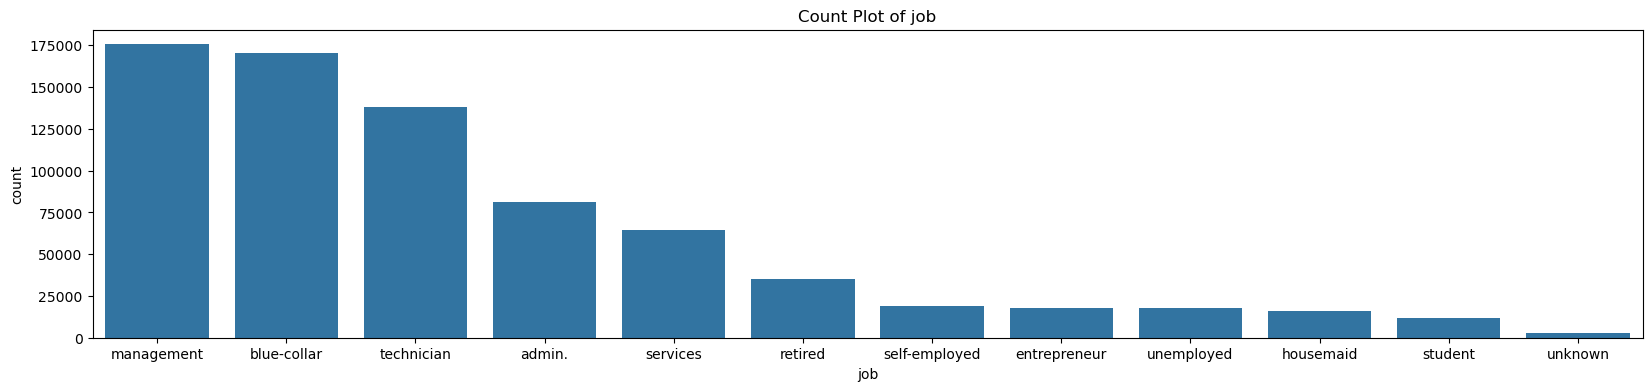

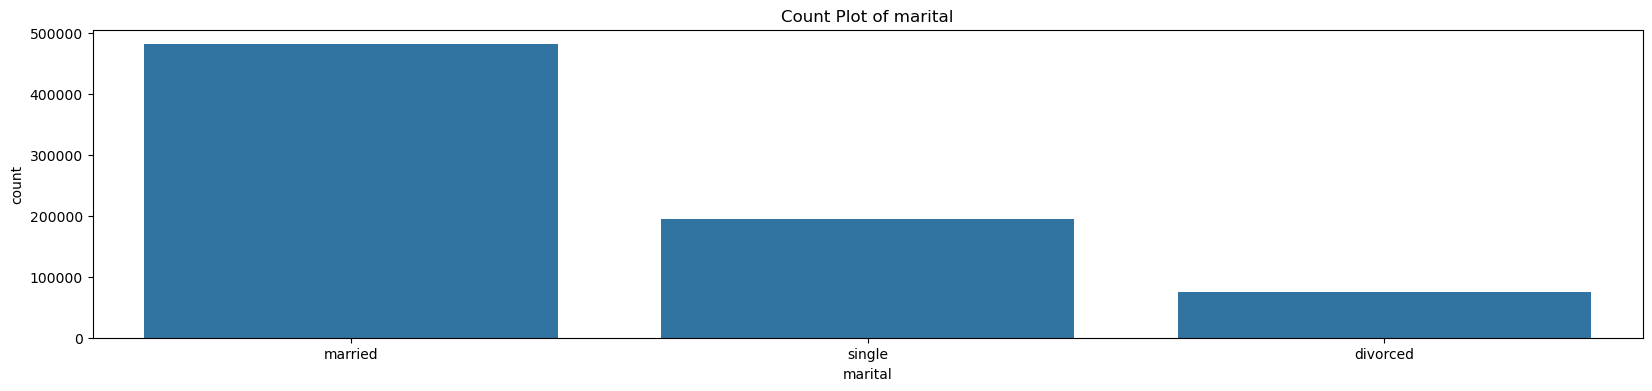

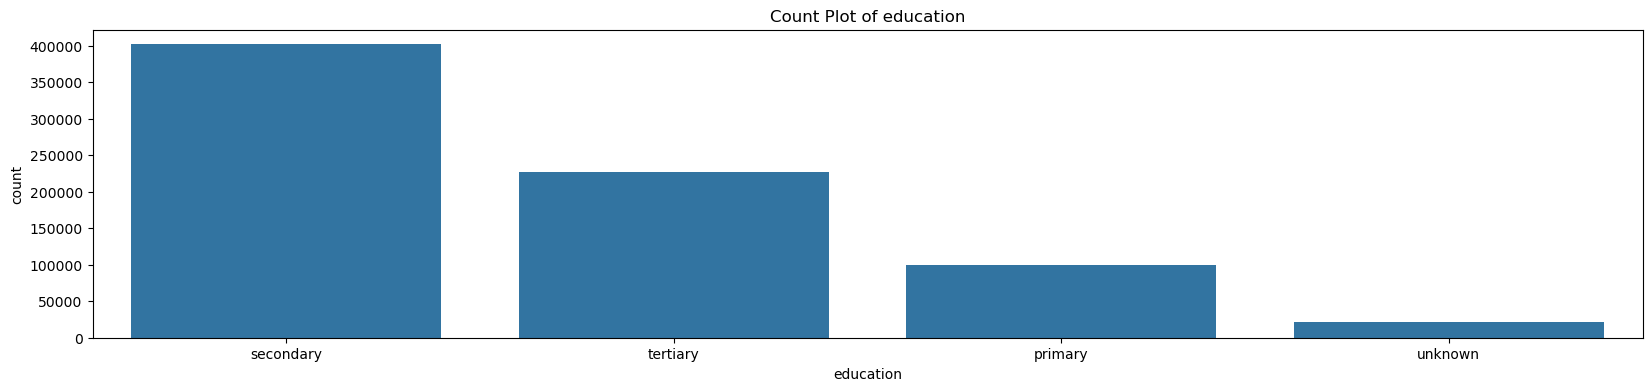

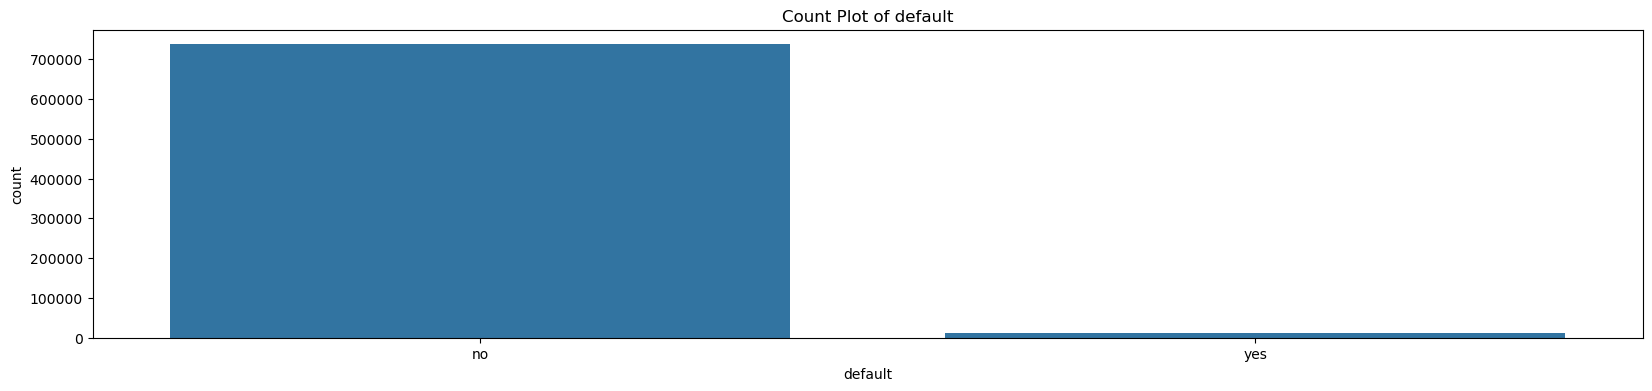

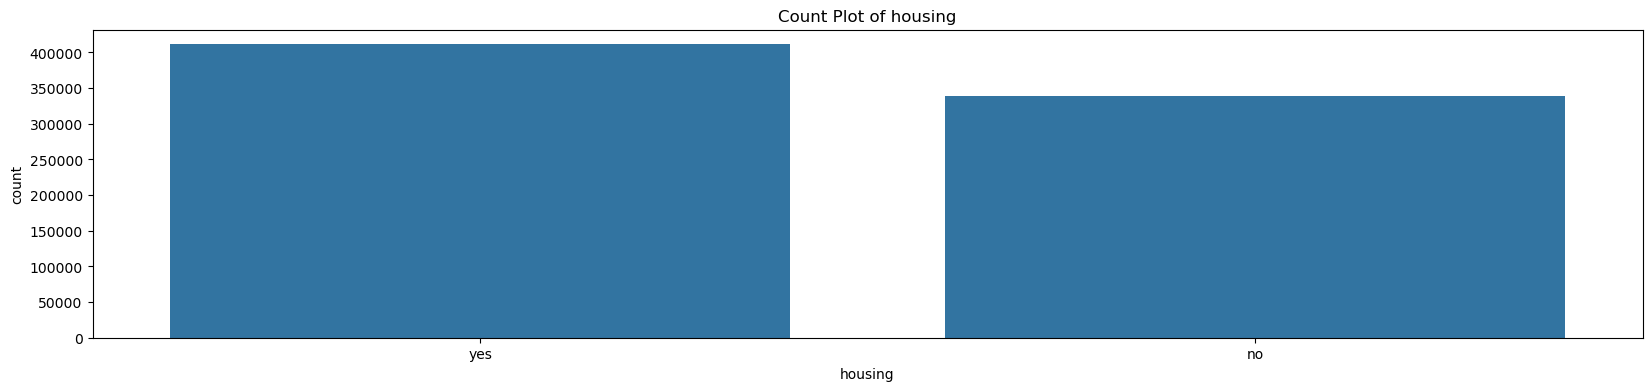

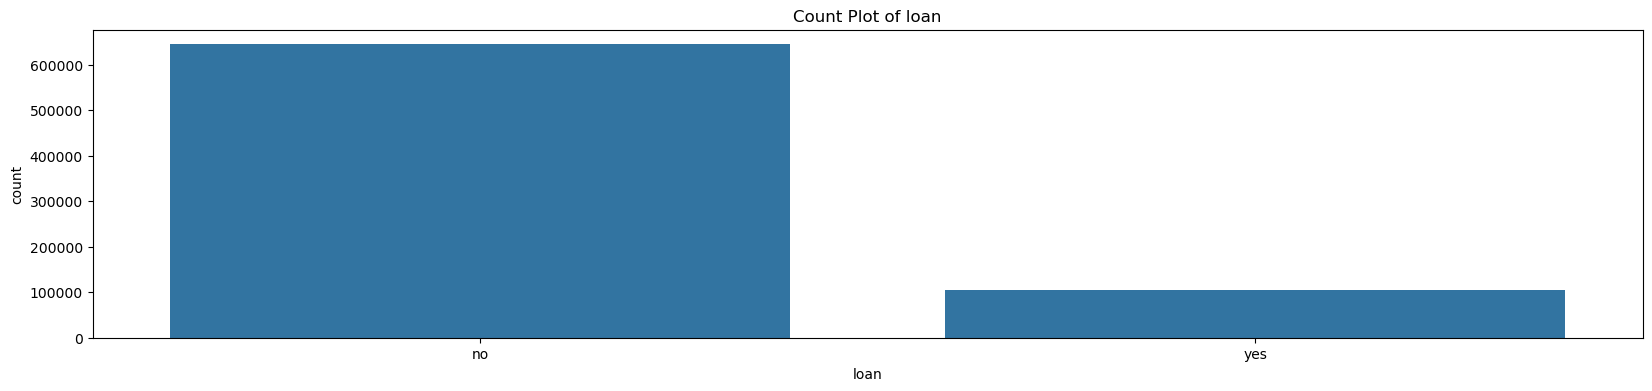

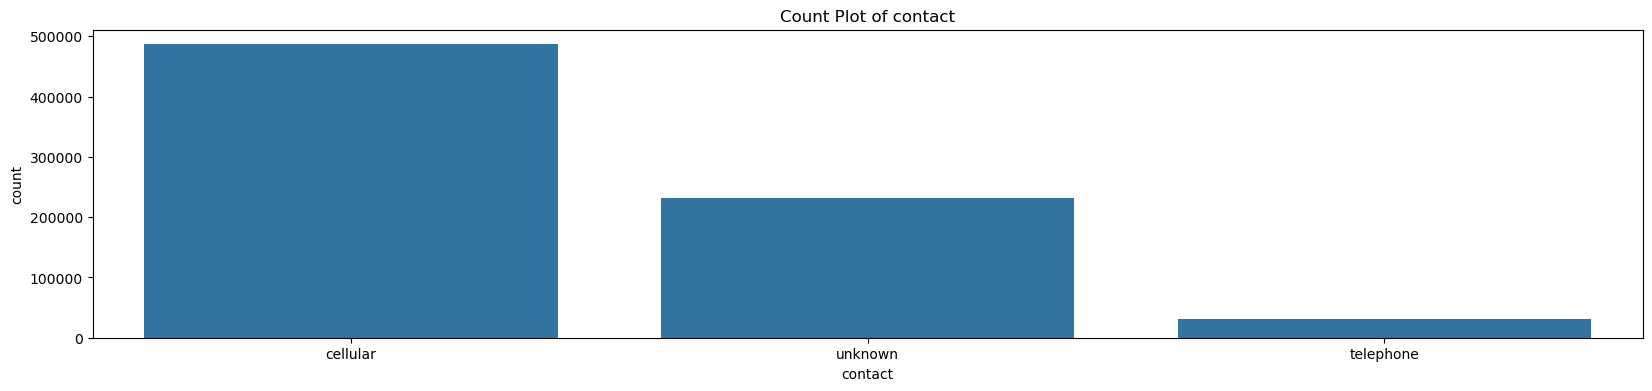

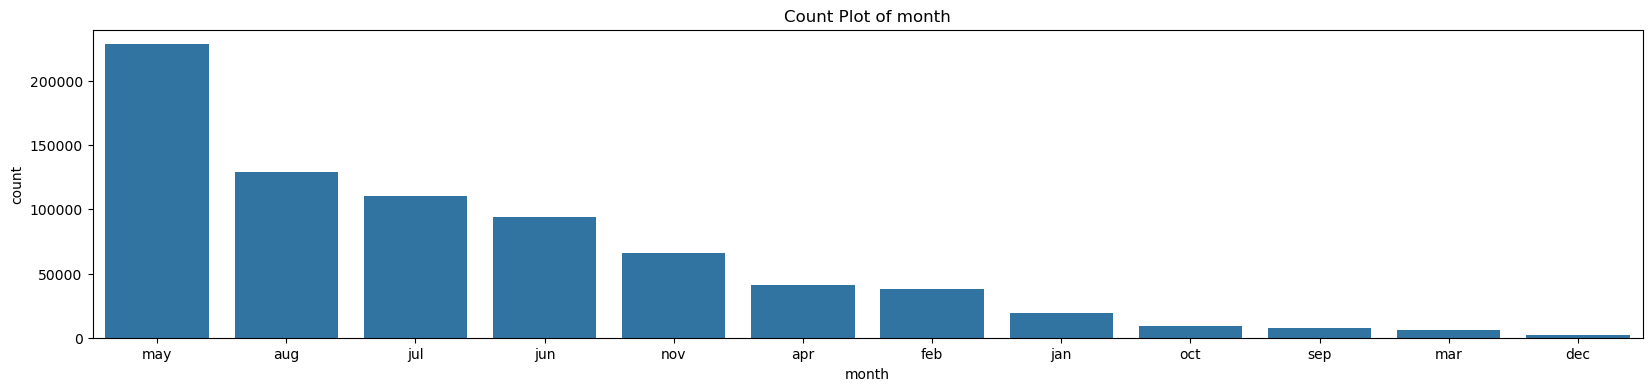

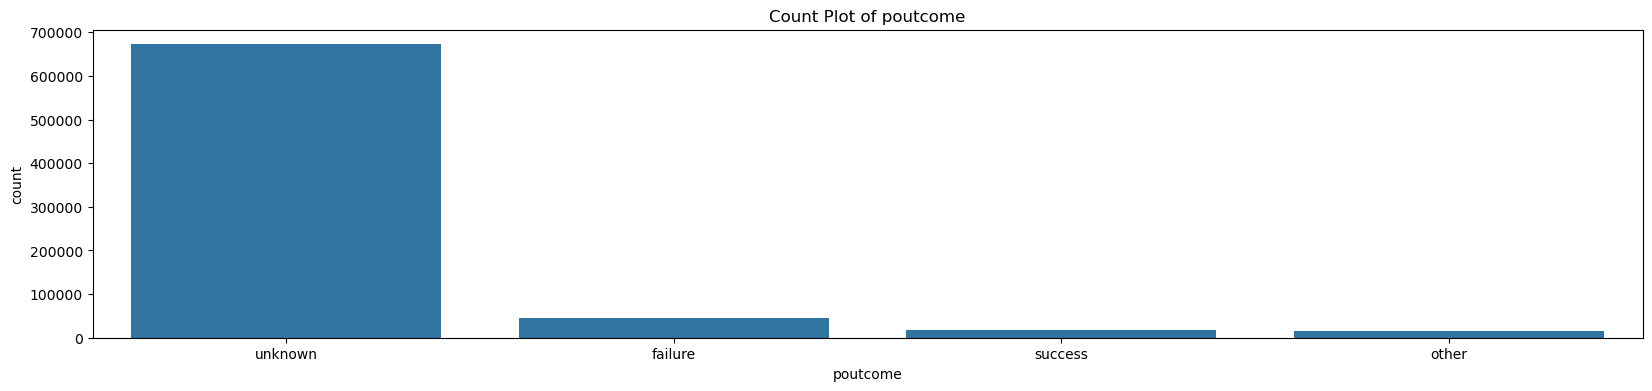

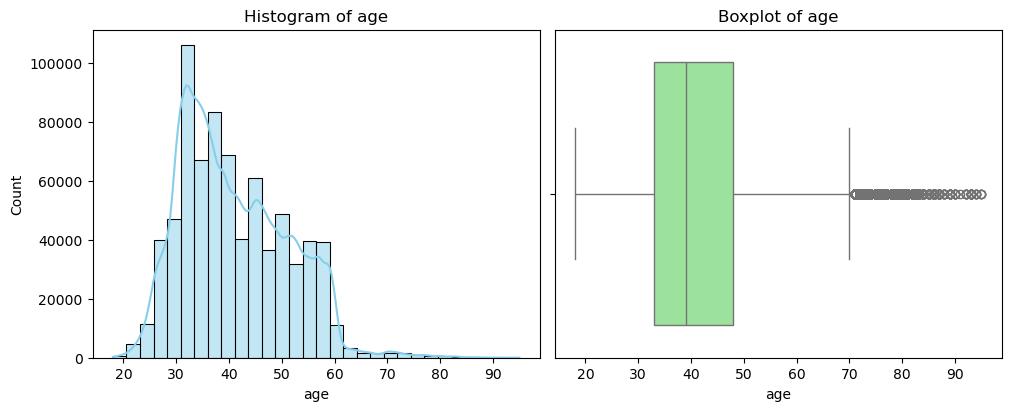

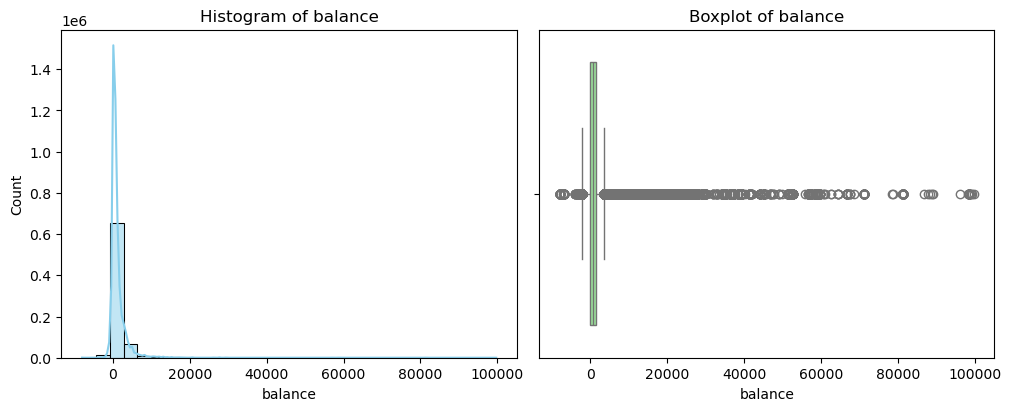

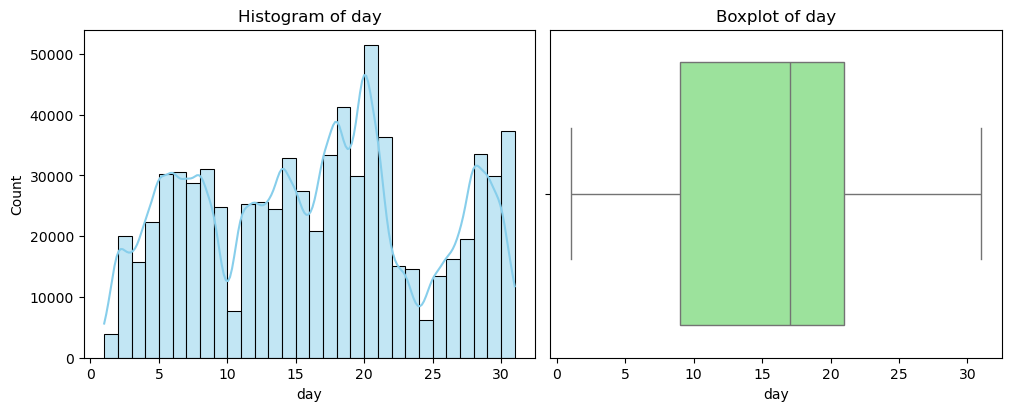

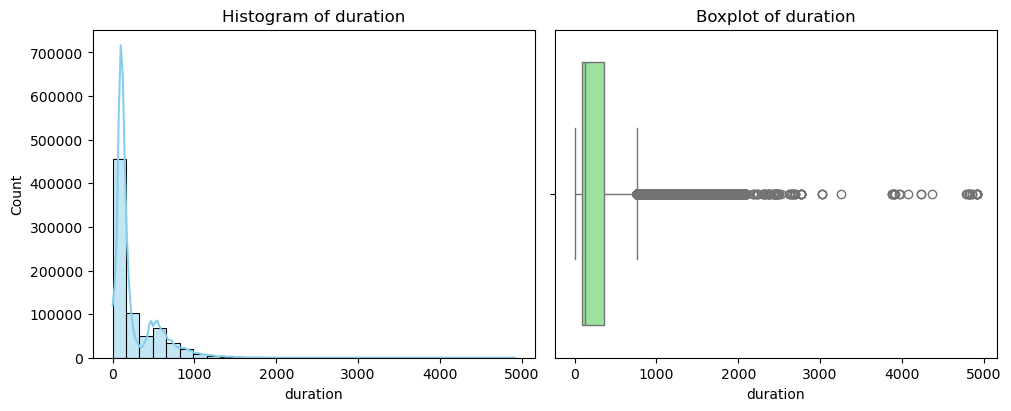

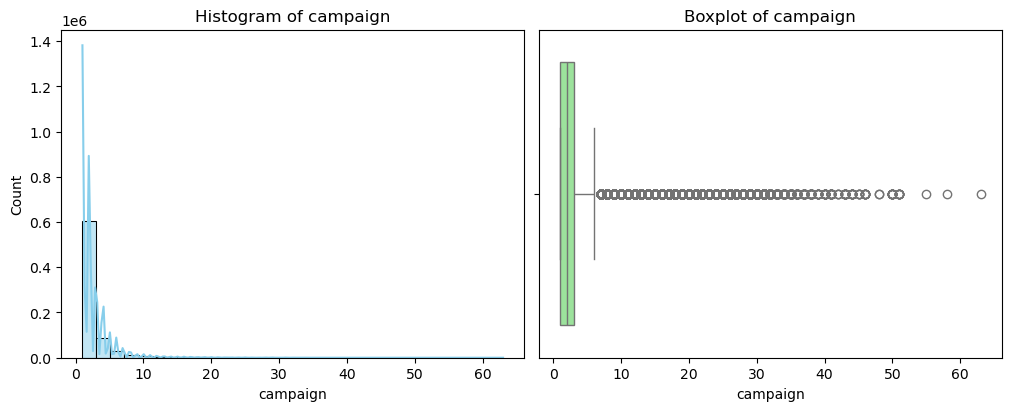

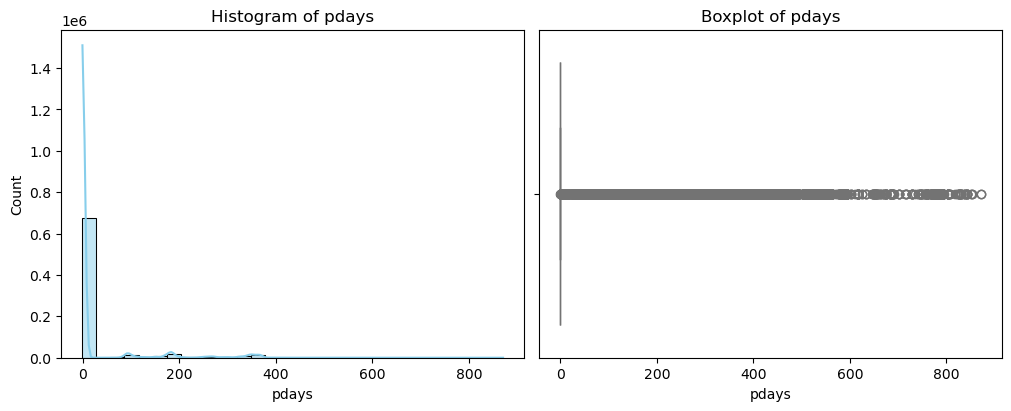

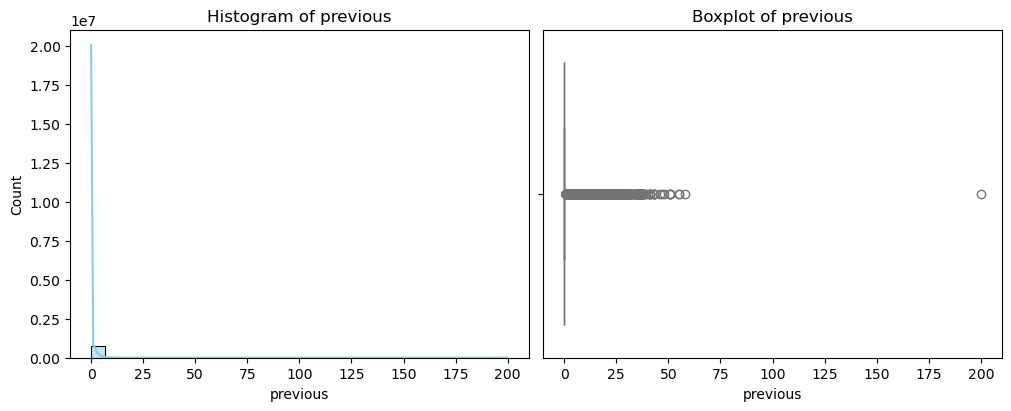

In [34]:
# --- Plotting ---
# 1) Count plots for categorical
for col in categorical:
    plt.figure(figsize=(20, 4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f"Count Plot of {col}")
    #plt.tight_layout()
    plt.show()

# 2) Histograms and boxplots for numeric
for col in numerical:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4),constrained_layout=True)
    
    # Histogram
    sns.histplot(data=df, x=col, kde=True, ax=axes[0], bins=30, color='skyblue')
    axes[0].set_title(f"Histogram of {col}")
    
    # Boxplot
    sns.boxplot(data=df, x=col, ax=axes[1], color='lightgreen')
    axes[1].set_title(f"Boxplot of {col}")
    
    #plt.tight_layout()
    plt.show()

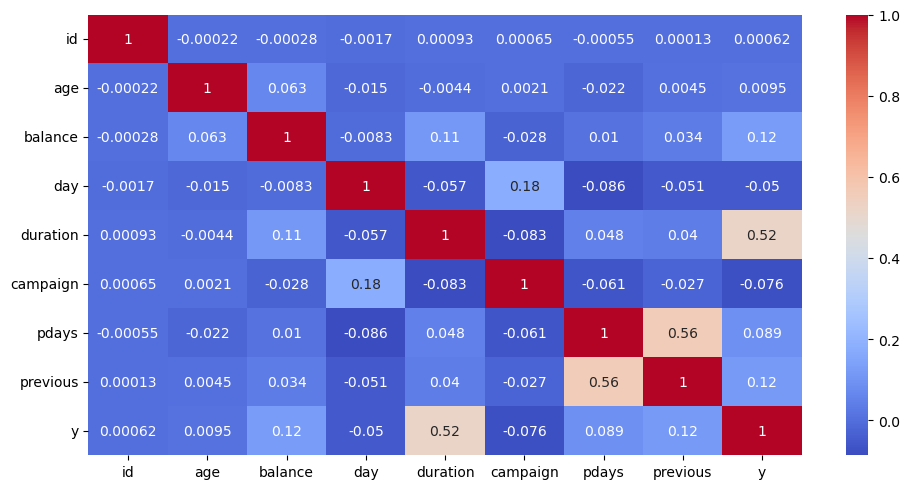

In [37]:
plt.figure(figsize=(10,5))
sns.heatmap(df.corr(numeric_only='True'),annot=True,  cmap= 'coolwarm')
plt.tight_layout()

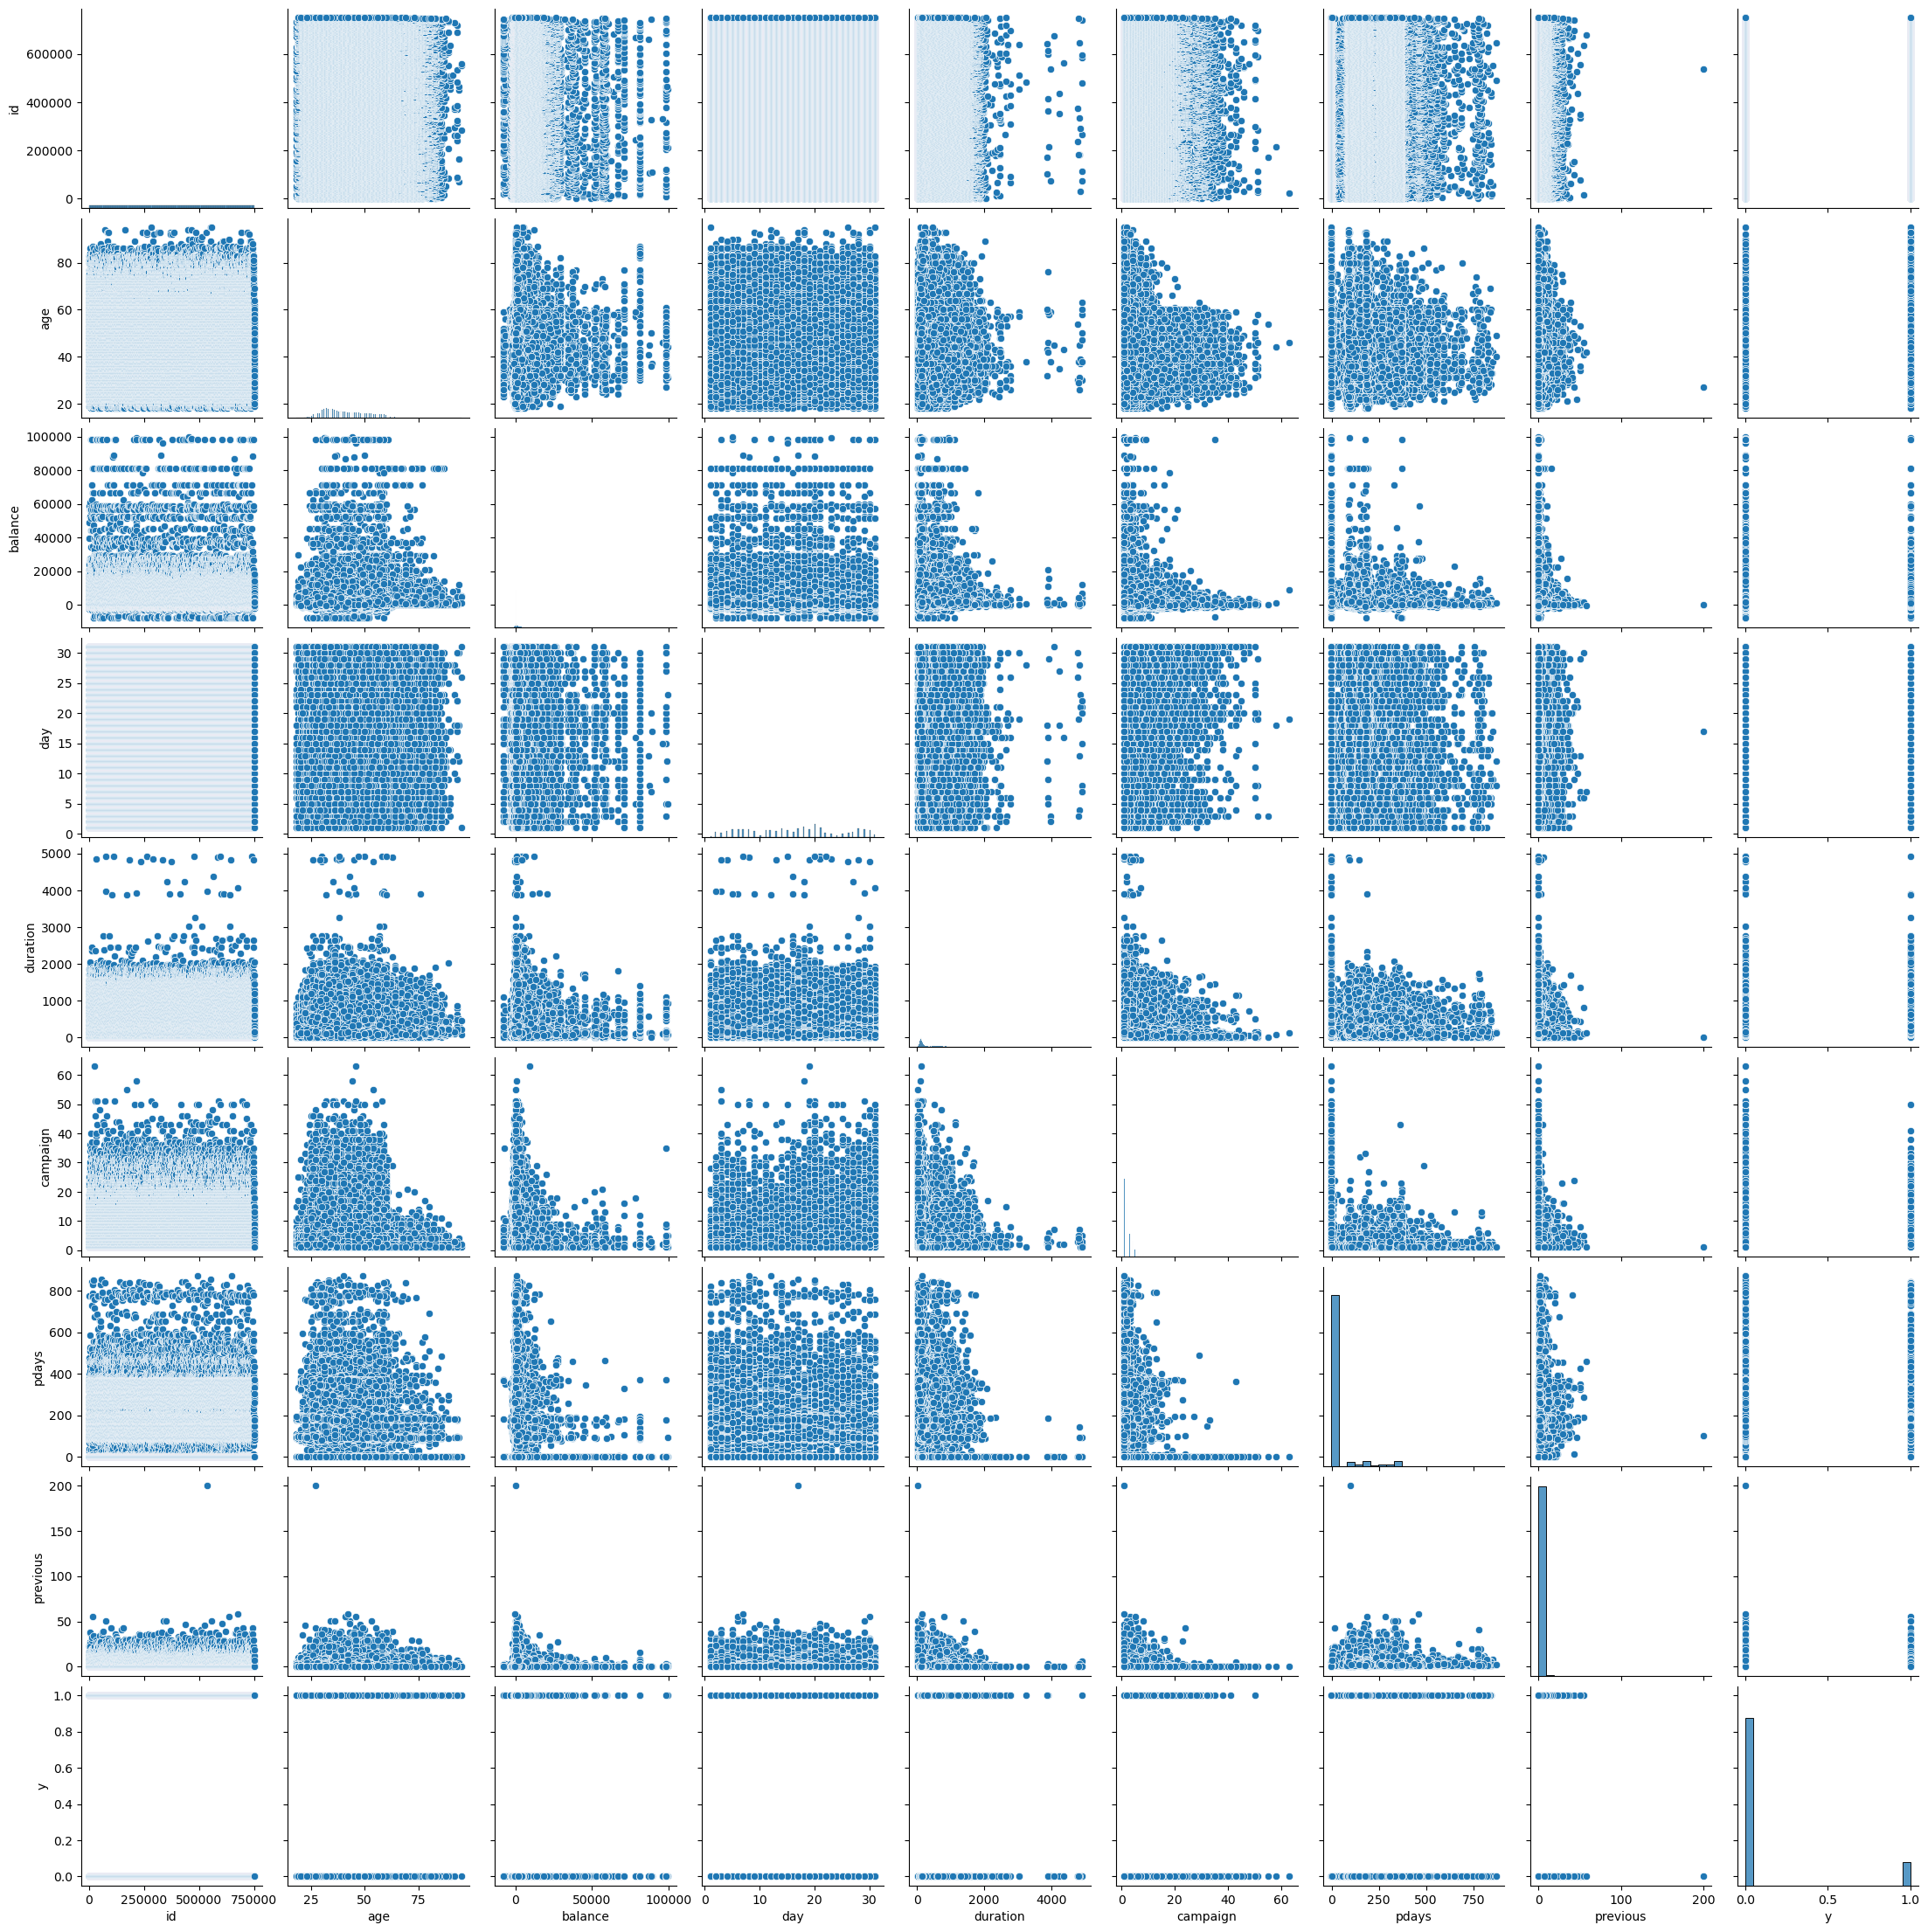

In [38]:
sns.pairplot(data = df,diag_kind='hist')

In [109]:
# Split Data
y=df[['y']]
X=df.drop(columns='y',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [63]:
X_train.columns

Index(['id', 'age', 'job', 'education', 'default', 'balance', 'housing',
       'loan', 'day', 'duration', 'campaign', 'pdays', 'previous', 'poutcome',
       'education_ord', 'marital_married', 'marital_single',
       'contact_telephone', 'contact_unknown', 'month_sin', 'month_cos'],
      dtype='object')

In [110]:
y

,y
0,0
1,0
2,0
3,0
4,1
...,...
749995,1
749996,0
749997,0
749998,0


In [111]:
# ============================================
# One-Hot Encoding (Low Cardinality Nominal)
# ============================================
one_hot_cols = ['marital', 'contact']
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ohe.fit(X_train[one_hot_cols])

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [72]:
# ============================================
# Pre Processing Traimn
# ============================================

In [112]:
## Categorical varibales encoded for train
col_encoded = ohe.transform(X_train[one_hot_cols])
cols = ohe.get_feature_names_out(one_hot_cols)
encoded_df=pd.DataFrame(col_encoded,columns=cols,index=X_train.index)
X_train.drop([c for c in cols if c in X_train.columns],axis=1,inplace=True)
X_train = pd.concat([X_train,encoded_df],axis=1)

In [113]:
# Train
X_train = preprocess_dataset(X_train, categorical_cols=categorical)

Categorical Feature Distributions:

--- job ---
job
management       140512
blue-collar      136323
technician       110295
admin.            65304
services          51360
retired           28171
self-employed     15255
entrepreneur      14145
unemployed        14092
housemaid         12768
student            9447
unknown            2328
Name: count, dtype: int64

--- marital ---
marital
married     384526
single      155881
divorced     59593
Name: count, dtype: int64

--- education ---
education
secondary    321278
tertiary     182071
primary       79617
unknown       17034
Name: count, dtype: int64

--- default ---
default
no     589721
yes     10279
Name: count, dtype: int64

--- housing ---
housing
yes    329074
no     270926
Name: count, dtype: int64

--- loan ---
loan
no     515909
yes     84091
Name: count, dtype: int64

--- contact ---
contact
cellular     389471
unknown      185155
telephone     25374
Name: count, dtype: int64

--- month ---
month
may    182661
aug    103057


In [75]:
# ============================================
# Pre Processing Test
# ============================================

In [114]:
X_test.columns

Index(['id', 'age', 'job', 'marital', 'education', 'default', 'balance',
       'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign',
       'pdays', 'previous', 'poutcome'],
      dtype='object')

In [115]:
## Categorical varibales encoded for test
col_encoded = ohe.transform(X_test[one_hot_cols])
cols = ohe.get_feature_names_out(one_hot_cols)
encoded_df=pd.DataFrame(col_encoded,columns=cols,index=X_test.index)
X_test.drop([c for c in cols if c in X_test.columns],axis=1,inplace=True)
X_test = pd.concat([X_test,encoded_df],axis=1)

In [116]:
# Test
X_test = preprocess_dataset(X_test)

In [117]:
X_train.columns

Index(['id', 'age', 'job', 'marital', 'education', 'default', 'balance',
       'housing', 'loan', 'contact', 'day', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'marital_divorced', 'marital_married',
       'marital_single', 'contact_cellular', 'contact_telephone',
       'contact_unknown', 'duration_sin', 'duration_cos', 'balance_log',
       'balance_sin', 'balance_cos', 'age_sin', 'pdays_sin', 'education_ord',
       'month_sin', 'month_cos'],
      dtype='object')

In [118]:
features = [
    'age',
    'age_sin',

    'education_ord',

    'balance',
    'balance_log',
    'balance_sin',
    'balance_cos',

    'default',
    'housing',
    'loan',

    'day',

    'duration',
    'duration_sin',
    'duration_cos',

    'campaign',

    'pdays',
    'pdays_sin',

    'previous',

    'marital_divorced',
    'marital_married',
    'marital_single',

    'contact_cellular',
    'contact_telephone',
    'contact_unknown',

    'month_sin',
    'month_cos'
]

In [106]:
X_train

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
385296,385296,53,self-employed,married,secondary,no,5,yes,no,cellular,21,nov,53,1,-1,0,unknown
696342,696342,40,entrepreneur,married,primary,no,759,no,no,cellular,20,nov,68,1,-1,0,unknown
350451,350451,53,admin.,married,secondary,no,1473,yes,yes,cellular,20,nov,509,2,-1,0,unknown
545334,545334,24,technician,single,secondary,no,855,yes,no,cellular,16,apr,1205,1,-1,0,unknown
138700,138700,49,admin.,married,secondary,no,2058,no,no,cellular,30,apr,1842,1,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549877,549877,37,technician,married,secondary,no,4389,yes,no,cellular,29,aug,77,2,-1,0,unknown
140612,140612,40,management,married,tertiary,no,3158,yes,no,cellular,31,jul,126,3,-1,0,unknown
318186,318186,34,technician,married,secondary,no,-32,no,no,cellular,11,aug,135,5,-1,0,unknown
527966,527966,37,management,single,tertiary,no,810,yes,no,unknown,13,may,82,2,-1,0,unknown


In [120]:
# -------------------------------
# Model Training (Logistic Regression via SGD)
# -------------------------------
model_name = "LogisticRegression_SGD"

classifier = SGDClassifier(
    loss="log_loss",
    max_iter=20,
    random_state=42
)

classifier.fit(X_train[features],y_train[target])

C:\Users\tejam\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGDClassifier(loss='log_loss', max_iter=20, random_state=42)

In [123]:
# -------------------------------
# Final Evaluation
# -------------------------------
y_test_pred = classifier.predict(X_test[features])

final_metrics = compute_classification_metrics(
    y_test['y'],
    y_test_pred
    
)


In [124]:
final_metrics

{'accuracy': 0.884,
 'auc': np.float64(0.6371),
 'precision': 0.5332,
 'recall': 0.3117,
 'f1_score': 0.3934,
 'mcc': np.float64(0.3489)}

In [142]:
# Save model
model_file_path = "logistic_regression_sgd.joblib"
joblib.dump(classifier, model_file_path)

# Save metadata
save_model_metadata(
    model_name=model_name,
    parameters=classifier.get_params(),
    metrics=final_metrics,
    model_path=model_file_path
)
